# seattle bridges: what's up?
Analysis of bridge closure events across the city from winter to summer 2016

In [8]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
import glob
# from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def days_hours_minutes(td):
    """
    convert a timedate object into a dictionary with days, hours, and minutes elements
    """
    mydict = {}
    mydict['days'] = td.days
    mydict['hours'] = td.seconds//3600
    mydict['minutes'] = (td.seconds//60)%60
    return mydict

Tweets are stored periodically by scraping Twitter history. Let's combine what's available into a single Pandas dataframe.

In [10]:
# We know all csv files end in 2016
bridge_files = glob.glob("../data/bridge/*2016.csv")

frame = pd.DataFrame()
list_ = []
for f in bridge_files:
    df = pd.read_csv(f)
    list_.append(pd.read_csv(f))
df = frame.append(list_)

df = df.drop_duplicates()

## Data Format
Each row of data represents either a bridge closure or opening. In my own thinking, a closure means that the bridge is unaccessible to road users. Either definition is confusing because when a bridge is "closed" for usage, the physical span is actually "opened." Let's stick with bridge closed = bad for road users. 

The data has a unique tweet ID, a time tag, and contents of an automated tweet.

In [11]:
df.head()

,id,created_at,text
0,693601965163442176,2016-01-31 01:09:29,The Fremont Bridge has reopened to traffic - ...
1,693599354439933952,2016-01-31 00:59:07,The Fremont Bridge has closed to traffic - 4...
2,693590335797092352,2016-01-31 00:23:16,The Montlake Bridge has reopened to traffic ...
3,693588978541309952,2016-01-31 00:17:53,The Montlake Bridge has closed to traffic - ...
4,693588472922177536,2016-01-31 00:15:52,The University Bridge has reopened to traffi...


The tweet text contains useful data that we need to parse. We can split the text in several ways to get information on the bridge, the time (which is different than the "created_at" tweet time, the event (whether the bridge is closing or reopening to road traffic), and finally the date.

In [12]:
# Extract data from CSV by splitting text columns
df['bridge'] = df['text'].map(lambda x: x.split('The ')[-1].split(' Bridge')[0])
df['time'] = df['text'].map(lambda x: x.split('- ')[-1])
df['event'] = df['text'].apply(lambda x: 'closed' if ('closed' in x) else 'open')
df['date'] = df['created_at'].map(lambda x: x.split(' ')[0])
df_clean = df[['bridge','time','event', 'date', 'text']]

Now we have all the relevant open and closing information we need to reorganize  to turn open and close events into periods of closure. In most cases the data parsing worked correctly, but as is often the case, not every case worked out perfectly. Group the data to check for errors.

In [13]:
# Some of the fields include errors we need to remove
df_clean.groupby('bridge').count()

,time,event,date,text
bridge,,,,
1st Ave S,1589,1589,1589,1589
1st Ave S bridge has closed to traffic,1,1,1,1
@breannemci Federal law gives marine traffic the right-of-way over vehicular traffic. More info here: https://t.co/y3dCkAunq9,1,1,1,1
@wsdot @trevortinker @breannemci Federal law gives marine traffic right-of-way over vehicular traffic. More info: https://t.co/y3dCkAunq9,1,1,1,1
A demonstration is blocking the intersection at Montlake Blvd NE &amp; NE Pacific St. Use alt routes. https://t.co/l6j6PUzwc7,1,1,1,1
Ballard,5001,5001,5001,5001
Fremont,5984,5984,5984,5984
Let's loop in @wsdot_traffic @pursuittt,1,1,1,1
Lower Spokane St,2424,2424,2424,2424


We have a known set of real bridges we can use as a guide. The other non-bridge fields can be ignored. These are a consequence of this Twitter account sometimes being used by humans. In most cases, the tweets are automated, but sometimes a silly human gets on the horn to tweet additional info.

In [14]:
bridge_list = ['Ballard', 'Fremont', '1st Ave S', 'Montlake', 'Lower Spokane St', 'South Park', 'University']

In [15]:
# Select only rows with a bridge name in the bridge list
newdf = df_clean[df_clean['bridge'].isin(bridge_list)]

In [16]:
# There are still some records with bad data
# Get rid of date rows without dates

# first remove extra space in the date string
newdf['newtime'] = newdf['time'].str.lstrip()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
len(newdf)

20893

In [18]:
# Only include date rows with PM or AM text
newdf = newdf[newdf['newtime'].str.contains('PM|AM')]
len(newdf)

20885

In [19]:
# Convert the time text to a datetime object in pandas
newdf['timeobj'] = pd.to_datetime(newdf['newtime'], format="%I:%M:%S %p", errors='coerce')

In [20]:
for i in xrange(len(newdf)):
    if not type(newdf['timeobj'].iloc[0]) == pd.tslib.Timestamp:
        print i

In [21]:
# NOTE: data is presented with most recent events at top, makes more sense chronologically to put oldest at top row
# REVERSE the DF
# newdf = newdf.reindex(index=newdf.index[::-1])

In [22]:
# Drop some nats (not a time)
newdf = newdf.dropna()

In [23]:
# newdf is what we want to store to get the status of each bridge
newdf.to_csv('../data/bridge/bridge_status.csv',index=False)

In [24]:
# We need to know each closure event (bridge opening for a ship to cross)
# and calculate the subsequent re-opening time, usually from the following row

# do that by getting the index of each bridge closure and taking index+1 for the re-opening
# Loop through each bridge separately
bridgelist = newdf.groupby('bridge').count().index

# initialize result arrays
duration = []
closehr = []
closemin = []
closesec = []
bridgename = []
date = []

for bridge in bridgelist:
#     print bridge
    # select records for each bridge
    bridgedf = newdf[newdf['bridge'] == bridge]
    
    # reindex this slice because we need to consider each row i and i+1 for these bridges
    bridgedf.reset_index(inplace=True)

    # Get index of all bridge closure events
    closure_event_index = bridgedf[bridgedf['event'] == 'closed'].index

    # Loop through all closure events except the last two (since we compare i and i+1)
    for i in closure_event_index[:-2]:
#         print i
        # if the next entry is a reopening, compute the closure time
        if bridgedf.iloc[i+1]['event'] == 'open':
            # compute the close time between i and i+1
            
            # get total closure time by subtracting time stamps between close and open
            duration.append((bridgedf.iloc[i+1]['timeobj'] - bridgedf.iloc[i]['timeobj']).seconds)
            
            # also record the start of this closure
            closetime = bridgedf.iloc[i]['timeobj']
            closehr.append(closetime.hour)
            closemin.append(closetime.minute)
            closesec.append(closetime.second)
            bridgename.append(bridge)
            date.append(bridgedf.iloc[i]['date'])
        else:
            # if i+1 is not an opening there is an error so skip this opening event
            continue
    
# Convert to dataFrame
df = pd.DataFrame(data=[duration, closehr,closemin,closesec,bridgename, date]).T
df.columns=['Duration','Closure Hour','Closure Minute','Closure Second','Bridge', 'Date']

# Separate date column into month, day, year values
df['Year'] = [i.split('-')[0] for i in df['Date'].values]
df['Month'] = [i.split('-')[1] for i in df['Date'].values]
df['Day'] = [i.split('-')[2] for i in df['Date'].values]

In [25]:
# Write results to dataframe
df.to_csv('bridge_results.csv')

## Results analysis

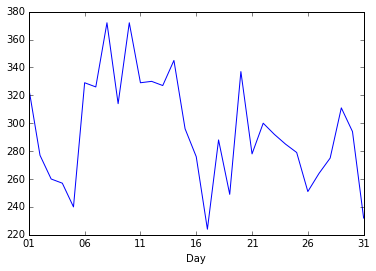

In [26]:
# Total closures (count) by day in minutes
df.groupby('Day').count()['Duration'].plot()

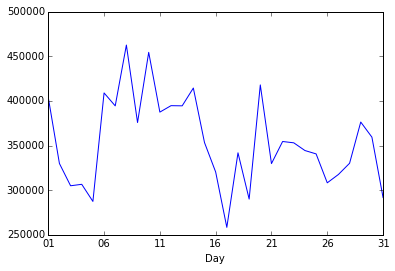

In [27]:
# Total closure time by day
(df.groupby('Day').sum()['Duration']/60).plot()


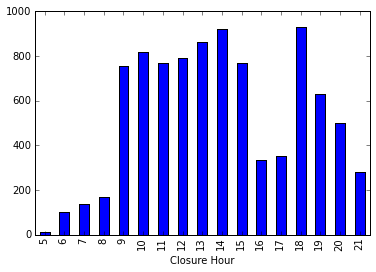

In [28]:
# Closures by time of day
df.groupby('Closure Hour').count()['Duration'].plot(kind='bar')

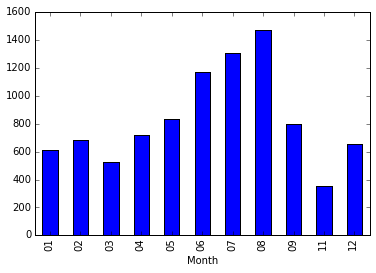

In [29]:
# Closures by month
df.groupby('Month').count()['Duration'].plot(kind='bar')

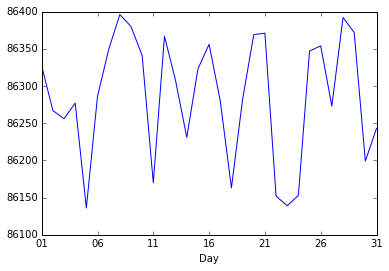

In [30]:
df.groupby('Day').max()['Duration'].plot()

In [31]:
# Looks there are some records with very long opening, perhaps errors?
# We can dig into that later, or just drop the really long records for now
df['Duration'].max()/3600

23

In [32]:
# Select closings less than 2 hours
df = df[df['Duration'] < 3600*2]

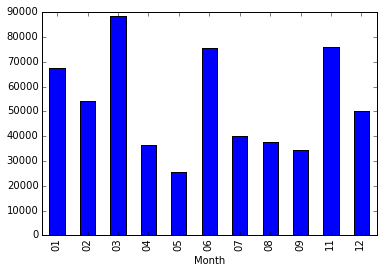

In [33]:
# Total time bridge is inaccessible
df.groupby('Month').sum()['Duration'].plot(kind='bar')

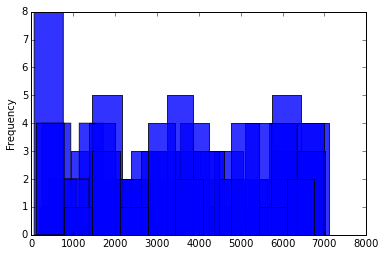

In [34]:
# Distribution by bridge
for bridge in df.groupby('Bridge').count().index:
    outdf = df[df['Bridge'] == bridge]
    outdf['Duration'].plot(kind='hist',subplots=True, alpha=0.8)
#     newdf['Duration'].hist(by=newdf.index,subplots=True, alpha=0.8)

In [ ]:
# 

## Impacts


* extrapolate value of time costs
* consider impacts of reliability in mode and route choice

## Forecasting
Is it possible to forecast the likelihood of a bridge closure based on time of day, month, freight traffic, weather or tides?